### MNIST

The MNIST dataset is a set of 70,000 small images of handwritten digits by high school students and employees of US Census Bureau.Whenever
anyone wants to learn ML or test something in the classification they usually do it through MNIST dataset.

Following code fetches the MNIST dataset. Since, fetch_mldata() library is deprecated we can use fetch_openml()

To know more about the pixels being stored in computer:

https://www.analyticsvidhya.com/blog/2021/03/grayscale-and-rgb-format-for-storing-images/



In [1]:
import numpy as np
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
# To remove warnings in jupyter notebook
import warnings
warnings.filterwarnings('ignore')


In [2]:
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

In [3]:
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False)
    mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings
    sort_by_target(mnist) # fetch_openml() returns an unsorted dataset
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')
mnist["data"], mnist["target"]

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0, 0, 0, ..., 9, 9, 9], dtype=int8))

- DESCR key: Used to describe the dataset
- data : Containing an array with one row per instance and one column per feature
- target: A target key containing an array with labels

In [4]:
# A look at the arrays
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [5]:
y.shape

(70000,)

There are around 70,000 images and each image has 784 features. This is because each image is 28X28 pixels and each feature
represents one pixel's intensity, from 0 to 255. Where values near to 0 represents black color and nearing 255 implies lighter color or white.

In [6]:
28*28

784

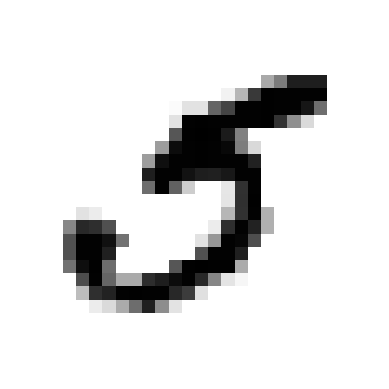

In [7]:
some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = mpl.cm.binary,
           interpolation="nearest")
plt.axis("off")

#save_fig("some_digit_plot")
plt.show()

In [8]:
y[36000]

5

In [9]:
def plot_digit(data):
    image = data.reshape(28,28)
    plt.imshow(image, cmap=mpl.cm.binary,
              interpolation="nearest")
    plt.axis("off")

In [10]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

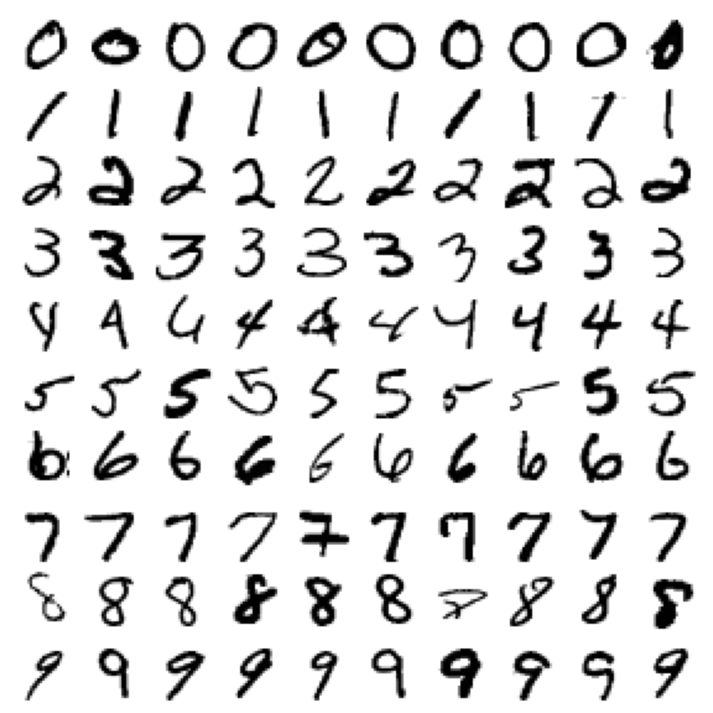

In [11]:
plt.figure(figsize=(9,9))
example_images = np.r_[X[:12000:600], X[13000:30600:600], X[30600:60000:590]]
plot_digits(example_images, images_per_row=10)
#save_fig("more_digits_plot")
plt.show()

In [12]:
# Splitting the dataset into train and test set before inspecting the data closely
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Shuffling of the train dataset for better predictions

In [13]:
import numpy as np
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index],y_train[shuffle_index]

### Training a Binary Classifier

Let's us try understanding a digit 5.

In [14]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

Time to pick the classifier and train it, it can be feasible using the SGD(Stochastic Gradient Descent) classifier, using Scikit-learn's SGDClassifier which is capable of handling very large datasets efficiently.

Let's create an SGDClassifier and train it on the whole training set

In [15]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [16]:
sgd_clf.predict([some_digit])

array([ True])

### Measuring Accuracy Using Cross-Validation

In [17]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42,shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.96095
0.9319
0.96485


We can make use of StratifiedKFold which performs stratified sampling to produce folds that
contain a representative ratio of each class.

At each iteration the code,
- creates clone of the classifier
- trains that clone on the training folds
- Make predictions on the test fold.

In [18]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9604, 0.9722, 0.9145])

Here, the accuracy is 95% on all cross-validation folds.

Let us look at a very dumb classifier that just classifies every single image in the "not-5" class category.

In [19]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self,X,y=None):
        pass
    def predict(self,X):
        return np.zeros((len(X),1),dtype=bool)

In [20]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf,X_train,y_train_5,cv=3,scoring="accuracy")

array([0.91175, 0.90675, 0.91045])

Here, it gives 90% accuracy, which means that 10% of the images are 5s, so if we guess the image is not a 5 there is 90% chance that we are correct.
This also states that accuracy is not a preferred performance measure for classifiers, when we are dealing with <i>skewed datasets</i>

### Confusion Matrix

A better way to evaluate the performance of a classifier.

Before plotting a confusion matrix we need to have set of predictions, so that they can be compared to the actual targets. For which, we can 
make use of cross_val_predict() function that performs K-fold cross-validation.


In [21]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [22]:
# Now, we shall get the confusion matrix using the confusion_matrix() function
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_train_5, y_train_pred)
cf_matrix

array([[52584,  1995],
       [ 1063,  4358]], dtype=int64)

<Axes: >

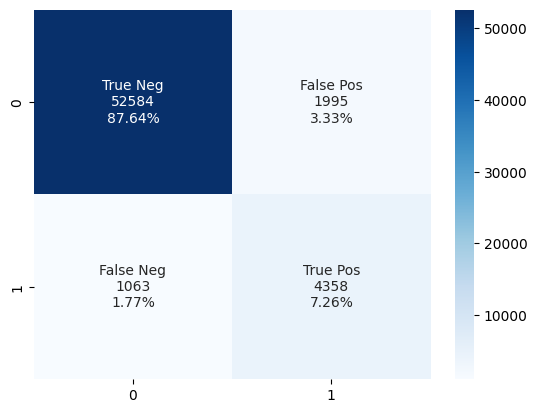

In [23]:
import seaborn as sns
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

Here, true negative are the non-5 which are correctly classified , False Negative are the Non-5 which are classified wrongly.
True Positive are the 5's are correctly classified.

In [24]:
# For prefect prediction which includes only 5 number
y_train_perfect_predictions = y_train_5

confusion_matrix(y_train_5,y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

- Precision = TP/(TP + FP), where TP: No of true positives, FP: Number of False positives
    
    Precision is used with another metric called <i>recall</i> also called <i>sensitivity</i> or <i> true positive rate</i>(TPR).
    
- Recall = TP / (TP + FN)

### Precision and Recall


In [25]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.6859751298599087

In [27]:
3273/(3273 + 1213)

0.7296032099866251

In [26]:
recall_score(y_train_5,y_train_pred)

0.8039107175797823

In [28]:
3273/(3273 + 2148)

0.6037631433314886

When it claims that an image represents a 5, it is correct only 77% of the time and detects 79% of the 5s.

Inorder to maintain a harmonic mean of precision and recall, we use the f1-score.Well the regular mean treats all values equally,
but the harmonic mean gives more weight to the lower value. As a result, the classifier will only get a high F1 score if both
recall and precision are high.

In [29]:
from sklearn.metrics import f1_score
f1_score(y_train_5,y_train_pred)

0.7402751826057414

f1_score favors classifiers that have similar precision and recall. 

For example, if you trained a classifier to detect videos that are safe for kids, you would probably prefer a classifier that rejects many good videos(low recall) but keeps only safe ones(high precision),
rather than a classifier that has a much higher recall but lets a few really bad videos to show up.

On the other hand, if we train a classifier to detect shoplifters on surveillance images: if the classifier has 30% precision as long as it has 99% recall(sure, the security
guards will get a few false alerts, but almost all shoplifters will get caught).
    
Unfortunately, we can't have it both ways: increasing precision reduces recall and vice-versa. This is called <i>precision/recall tradeoff</i>.


### Precision/Recall Tradeoff

Scikit-learn doesn't let to set the threshold directly, but it allows us to access the decision scores that it uses to make predictions.
Instead of calling the classifier's predict() method, we can call it's decision_function() method, which returns a score for each instance and
then make predictions based on those scores using any threshold.

In [30]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2665.09376197])

In [31]:
threshold = 0

In [32]:
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

Let us consider the threshold as 5000.

In [33]:
threshold = 5000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

This confirms that raising the threshold reduces the recall.Example: If you consider number 5 the classifier detects it when the threshold is 0,
    but it misses it when the threshold is increases to 5,000.

#### So,how do we decide which threshold to use?

We need to get the scores of all instances in the training set using the cross_val_predict(), specifying what we want to return decision scores
instead of predictions.

In [34]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

With these we can compute the precision and recall for all possible thresholds using the precision_recall_curve() function.

In [35]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

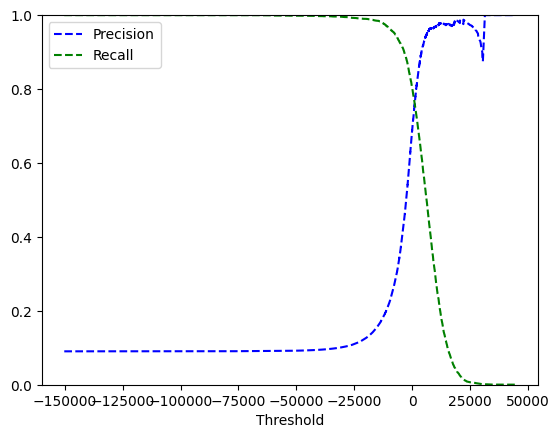

In [36]:
# Plot of precision and recall
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1],"b--", label="Precision")
    plt.plot(thresholds, recalls[:-1],"g--",label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0,1])
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

Now, we can simply select the threshold value that gives us the best precision/recall tradeoff to our task. Let's suppose we are aiming for 90% precision then we need to use a threshold of about 4,500.

In [44]:
y_train_pred_90 = (y_scores > 4500)

# Predictions of precision and recall
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

0.9138174625600453
0.5965688987271721


We get a 90% precision classifier. We can create a classifier with virtually any precision we want: just set high enough threshold.

### The ROC Curve

The receiver operating characteristic(ROC) curve is a common tool used for binary classifiers. It is similar to the precision/recall curve. However, it plots the
<i>true positive rate</i> against the <i>false positive rate</i>.

FPR is the ratio of negative instances that are incorrectly classified as positive.It is equal to one minus the true negative rate
which is the ratio of negative instances that are correctly classified as negative. 

TNR is called <i>specificity</i>. Hence, the ROC curve plots <i>sensitivity(recall)</i> versus <i>1 - specificity </i>

In [45]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

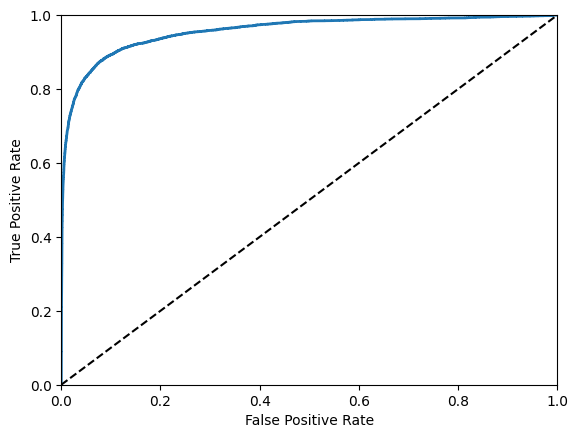

In [46]:
# We can plot FPR against TPR
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1],'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
plot_roc_curve(fpr, tpr)
plt.show()

The higher the recall(TPR), the more false positive rate(FPR) the classifier produces. The dotted line represents the ROC curve of a purely random classifier;
a good classifier stays as far away from that line as possible(top-left corner).

One way to compare the classifiers is to measure the <i>area under the curve(AUC)</i>. A perfect classifier has <i>ROC AUC</i> equal to 1,
whereas a purely random classifier will have ROC AUC=0.5. 

In [47]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9567344927486211

Now, a question may arise which one to prefer and when??

We should prefer the PrecisionRecall(PR) curve when the positive class is rare or when we care more about the false positives than the false negatives and the ROC curve otherwise.
Example, looking at the ROC curve we may think that the classifier is really good. But this is mostly because there are few positives(5s) compared to the negative(non-5s).
In contrast, PR curve makes it clear that the classifier has room for improvement.

In [48]:
# Let us consider the RandomForestClassifier and compare its ROC curve and ROC-AUC score to SGDClassifier
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [49]:
y_probas_forest

array([[0.06, 0.94],
       [1.  , 0.  ],
       [0.99, 0.01],
       ...,
       [1.  , 0.  ],
       [0.35, 0.65],
       [1.  , 0.  ]])

In [50]:
# plot of ROC curve , we need scores not probabilities
y_scores_forest = y_probas_forest[:,1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

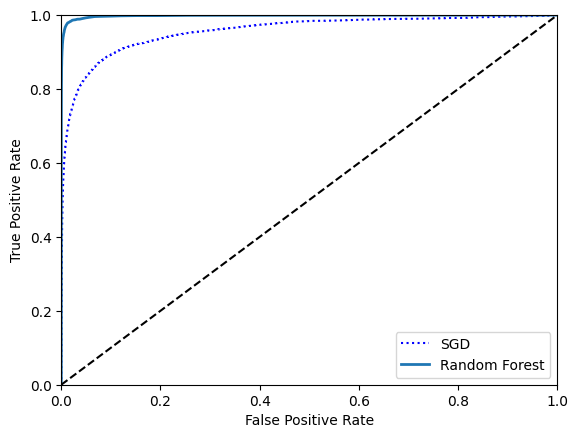

In [51]:
# Plot of ROC Curve
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

We can see that the RandomForestClassifier's ROC curve looks much better than the SGDClassifier's

In [52]:
roc_auc_score(y_train_5, y_scores_forest)

0.9982522233484834

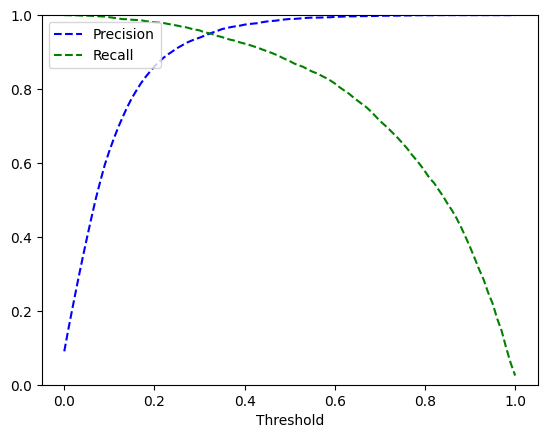

In [53]:
# Precision and recall
precisions_rf, recalls_rf, thresholds_rf = precision_recall_curve(y_train_5, y_scores_forest)

plot_precision_recall_vs_threshold(precisions_rf, recalls_rf, thresholds_rf)
plt.show()

In [54]:
y_train_pred_90_rf = (y_scores_forest > 0.45)
print(precision_score(y_train_5, y_train_pred_90_rf))
print(recall_score(y_train_5, y_train_pred_90_rf))

0.9840274969672462
0.8978048330566316


The precision at threshold 0.45 is 0.9845 while recall is 0.897.

### Multiclass classification

Let's try detecting more digits that just 5s. We shall use binary classifiers to distinguish between two classes, <i>multiclass classifiers</i> that 
can distinguish between more than two classes. Some algos such as <b>Random Forest classifiers or naive Bayes classifiers</b> are capable
of handling multiple classes directly. Others such as <b>Support Vector Machine classifiers or Linear classifiers</b> are strictly binary classifiers.

However, there are various strategies that we can use to perform multiclass classification using multiple binary classifiers.

For example, we can create a system that can classify the digit images into 10 classes(0 to 9) to train 10 binary classifiers,one for each digit. When we want to classify an image we can select the class whose classifier outputs the highest score. This is called the <i>one-versus-all(OvA)</i>

There can also be <i>one-versus-one(OvO)</i> where there are N classes, and we need to train N X (N - 1) / 2 classifiers.

For the MNIST problem, this means training 45 classifiers.The main advantage of OvO is that each classifier only needs to be trained on the 
part of the training set for the two classes that it must distinguish.

Some algorithms like SVM(Support Vector Machine) scale poorly with the size of the training set, so for these algorithms OvO is preferred since it is faster to
train many classifiers on small training sets than training few classifiers on large training sets.

In [55]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([5], dtype=int8)

The above code trains the SGDClassifier on the training set using the original target class from 0 to 9(y_train), instead of the 5-versus-all target classes(y_train_5). Then it makes a prediction.

Scikit-Learn actually trains 10 binary classifiers, got their decision scores for the image and selected the class with the highest score.


In [56]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[ -2826.90903117, -20896.78426482,  -5710.55386883,
         -1571.86344733,  -9444.80033216,   2191.39952175,
        -26107.00898705, -14599.62293426,  -9267.63064646,
        -14028.94696329]])

In [57]:
# Highest score is indeed corresponding to class 5
np.argmax(some_digit_scores)

5

In [58]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int8)

In [59]:
sgd_clf.classes_[5]

5

If we want to force ScikitLearn to use one-versus-one or one-versus-all, we can use the OnevsOneClassifier or OneVsRestClassifier classes. We can create an instance and pass a binary classifier to its constructor. For example, this code creates a multiclass classifier using the OvO strategy, based on the SGDClassifier.

In [60]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])


array([5], dtype=int8)

In [61]:
len(ovo_clf.estimators_)

45

In [62]:
# Training a RandomForestClassifier
forest_clf.fit(X_train,y_train)
forest_clf.predict([some_digit])

array([5], dtype=int8)

This time Scikit-Learn did not have to run OvA or OvO because RandomForest classifiers can directly classify instnaces into multiple classes.
We can call predict_proba() to get the list of probabilities that the classifier assigned to each instance of class.

In [63]:
forest_clf.predict_proba([some_digit])

array([[0.03, 0.  , 0.  , 0.07, 0.01, 0.85, 0.02, 0.02, 0.  , 0.  ]])

We can say that the classifier is confident about it's prediction: the 0.85 at the 5th index in the array means that the model estimates an 88% probability that the image represents a 5.It also thinks
that the image can be instead 3(7% of chance).

Next step is to evaluate these classifiers. As usual, we will be using the cross-validation. Let's evaluate the SGDClassifier's accuracy using the cross_val_score() function.

In [64]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.8662, 0.8559, 0.8556])

On an average the accuracy using the cross-validation is around 85%, incase we use a RandomForest, the accuracy might increase by 10%.But it might do much better, simply scaling the inputs.

In [65]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.90045, 0.9016 , 0.90445])

We can see that the accuracy got increased by 10% using the scaling technique.

### Error Analysis

If we look at the real project, we would follow the steps in our Machine Learning checklist: exploring data preparation options,
by trying out multiple models, shortlisting the best one , fine-tuning it using the hyperparameter tuning using GridSearchCV and
automating as much as possible.

We can look at the confusion matrix. For that, we need to make predictions using cross_val_predict() function , then call the
confusion_matrix() function.

In [66]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled,y_train,cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5604,    0,   19,    6,    9,   46,   34,    6,  198,    1],
       [   1, 6426,   40,   24,    3,   43,    4,    8,  180,   13],
       [  25,   32, 5264,   88,   73,   29,   61,   41,  335,   10],
       [  30,   23,  114, 5248,    1,  204,   25,   45,  375,   66],
       [   8,   15,   48,   13, 5240,    5,   32,   19,  301,  161],
       [  27,   19,   34,  160,   55, 4488,   82,   20,  471,   65],
       [  27,   15,   43,    1,   35,   96, 5571,    4,  126,    0],
       [  20,   14,   55,   25,   44,   10,    4, 5729,  158,  206],
       [  20,   61,   39,   96,    1,  130,   32,    7, 5416,   49],
       [  23,   25,   30,   61,  125,   40,    1,  178,  322, 5144]],
      dtype=int64)

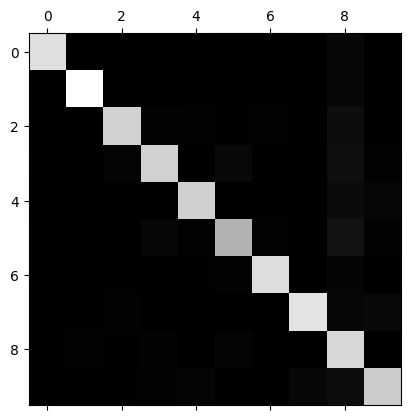

In [67]:
#image representation of confusion matrix using matplotlib's matshow() function
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

Here, the confusion matrix looks good, with most of the images along the diagonal, which means they were classified correctly. While
the image of 5's either does not perform well or have a fewer image.In fact, we can verify that both are the case.

Let's focus the plot on the errors. We need to divide each value in the confusion matrix by the no of images in the corresponding class
so that we can compare error rates instead of abs. no of errors.

In [71]:
row_sums = conf_mx.sum(axis=1,keepdims=True)
norm_conf_mx = conf_mx / row_sums

In [73]:
norm_conf_mx

array([[0.        , 0.        , 0.00320783, 0.001013  , 0.0015195 ,
        0.00776633, 0.00574033, 0.001013  , 0.03342901, 0.00016883],
       [0.00014832, 0.        , 0.00593296, 0.00355977, 0.00044497,
        0.00637793, 0.0005933 , 0.00118659, 0.02669831, 0.00192821],
       [0.00419604, 0.00537093, 0.        , 0.01477006, 0.01225243,
        0.00486741, 0.01023834, 0.0068815 , 0.05622692, 0.00167842],
       [0.00489317, 0.00375143, 0.01859403, 0.        , 0.00016311,
        0.03327353, 0.00407764, 0.00733975, 0.06116457, 0.01076496],
       [0.00136939, 0.00256761, 0.00821636, 0.00222527, 0.        ,
        0.00085587, 0.00547758, 0.00325231, 0.05152345, 0.02755906],
       [0.00498063, 0.00350489, 0.00627191, 0.02951485, 0.01014573,
        0.        , 0.01512636, 0.00368936, 0.08688434, 0.01199041],
       [0.00456235, 0.00253464, 0.00726597, 0.00016898, 0.00591416,
        0.0162217 , 0.        , 0.0006759 , 0.02129098, 0.        ],
       [0.00319234, 0.00223464, 0.0087789

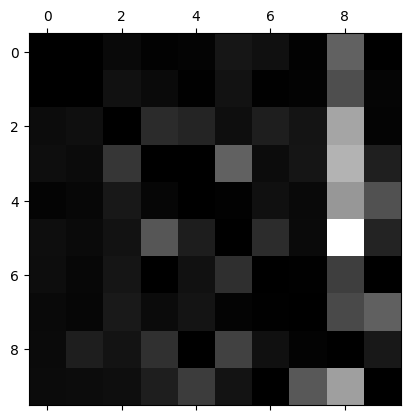

In [72]:
# Let's fill the diagonal with zeros to keep only the errors
np.fill_diagonal(norm_conf_mx,0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

From the above image we can see that the images for 8 digit aren't predicted well. The best prediction is for 0 or 1 as most of it
is dark in the above confusion matrix and the least is 8. Mostly it might be because of the closed loop like the digit 6 ot 8.

There are various ways to tackle it:-
    
    1. Getting more train data for these digits and retraining the model
    2. Another reason might be usage of SGDClassifier which is a linear model. All it does is assign a weight per class
    to each pixel, and when it sees a new image it just sums up the weighted pixel intensities to get a score for each class.
    Since 6s and 8s differ only by a few pixels, this model will easily confuse them.
    3. The classifier is quite sensitive to image shifting and rotation. So one way to reduce the 6/8 confusion is to preprocess
    the images to ensure that they are well centered and not too rotated. This will help reduce errors otherwise.

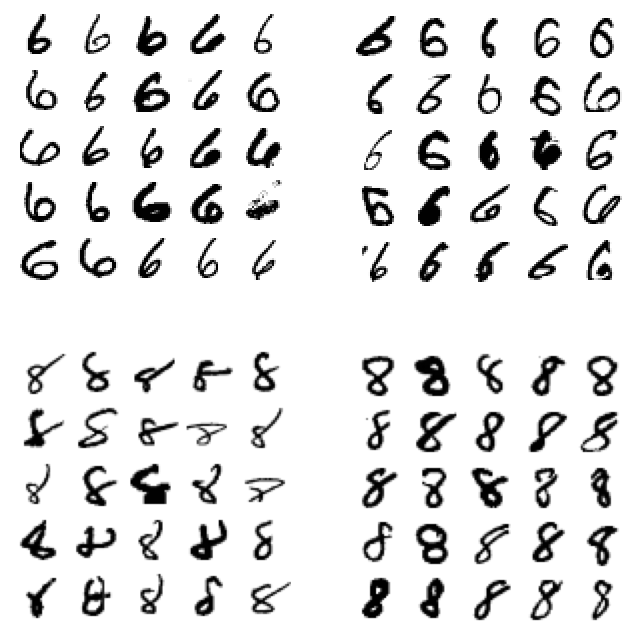

In [88]:
cl_a, cl_b = 6, 8
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
#save_fig("error_analysis_digits_plot")
plt.show()

### Multilabel classification

It is a classification system that outputs multiple binary labels . Example: We can create two labels as targets 
    
    1. Recognizing the digits as 7,8 or 9
    2. The second one belonging to an odd number like 1,3,5..
    
There are many ways of evaluating a multilabel classifier. However, the right metric is f1_score

### Multioutput classification

It is simply generalization of multilabel classification where each label can be multiclass(i.e. it can have more than two possible values).

In our dataset we can create the training set and test set by taking the MNIST image and add noise to their pixel intensities using Numpy's randint() function.

In [75]:
noise_1 = np.random.randint(0,100,(len(X_train),784))
noise_2 = np.random.randint(0,100,(len(X_test),784))
X_train_mod = X_train + noise_1
X_test_mod = X_test + noise_2
y_train_mod = X_train
y_test_mod = X_test

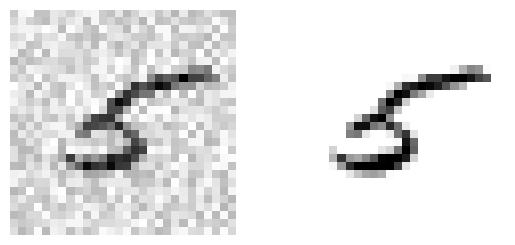

In [81]:
some_index=6000
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
#save_fig("noisy_digit_example_plot")
plt.show()

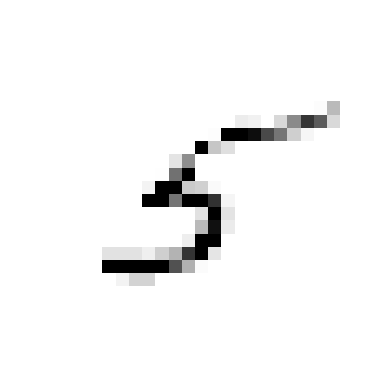

In [86]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod,y_train_mod)
clean_digit=knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

### Exercises

1. Using KNeighborsClassifier for Accuracy

In [90]:
# Using GridSearchCV for hyperparameter tuning on parameters weight and n_neighbors
# verbose : particular setting used when training and validating models
# n_jobs refers to multiple 

from sklearn.model_selection import GridSearchCV

param_grid = [{'weights':["uniform","distance"],'n_neighbors':[3,4,5]}]

knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf,param_grid,cv=5,verbose=3,n_jobs=-1)
grid_search.fit(X_train,y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid=[{'n_neighbors': [3, 4, 5],
                          'weights': ['uniform', 'distance']}],
             verbose=3)

In [91]:
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [92]:
grid_search.best_score_

0.9734833333333333

### Data Augumentation

Function that can shift the MNIST image in any direction (left, right, up or down) by one pixel. Then for each image we need to create
4 copies by one pixel and add them to the training set.Finally, train the best model on this training set and measure its accuracy on the test set.

In [93]:
from scipy.ndimage.interpolation import shift

In [94]:
def shift_image(image, dx, dy):
    image = image.reshape((28,28))
    shifted_image = shift(image,[dy,dx],cval=0,mode="constant")
    return shifted_image.reshape([-1])

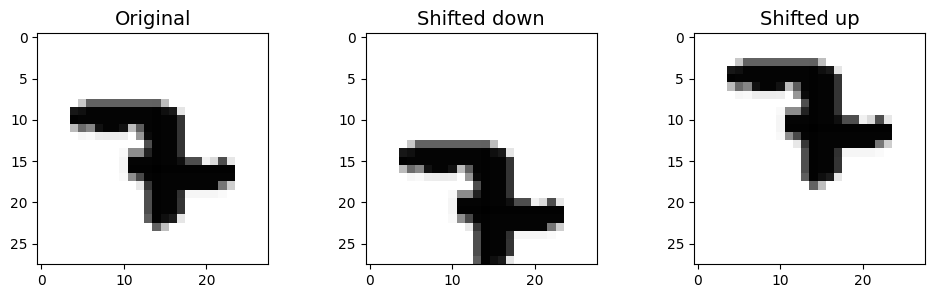

In [111]:
image = X_train[1000]
shifted_image_down = shift_image(image, 0, 5)
shifted_image_up = shift_image(image, 0, -5)

plt.figure(figsize=(12,3))
plt.subplot(131)
plt.title("Original",fontsize=14)
plt.imshow(image.reshape(28,28),interpolation="nearest",cmap="Greys")
plt.subplot(132)
plt.title("Shifted down",fontsize=14)
plt.imshow(shifted_image_down.reshape(28,28),interpolation="nearest",cmap="Greys")
plt.subplot(133)
plt.title("Shifted up",fontsize=14)
plt.imshow(shifted_image_up.reshape(28,28),interpolation="nearest",cmap="Greys")

In [114]:
# for each image we need to create 4 copies and add it to the training set
X_train_augumented = [image for image in X_train]
y_train_augumented = [label for label in y_train]

for dx, dy in ((1,0),(-1,0),(0,1),(0,-1)):
    for image, label in zip(X_train,y_train):
        X_train_augumented.append(shift_image(image,dx,dy))
        y_train_augumented.append(label)

X_train_augumented = np.array(X_train_augumented)
y_train_augumented = np.array(y_train_augumented)

In [115]:
# Shuffle the index using the np.random.permutation
shuffle_index = np.random.permutation(len(X_train_augumented))
X_train_augumented = X_train_augumented[shuffle_index]
y_train_augumented = y_train_augumented[shuffle_index]

In [116]:
# Using the KNeighborsClassifier
knn_clf = KNeighborsClassifier(**grid_search.best_params_)

In [117]:
knn_clf.fit(X_train_augumented,y_train_augumented)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [119]:
from sklearn.metrics import accuracy_score
y_pred = knn_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9763

We can see an accuracy increase on augumentation of training set.

### Tackle the titanic dataset

1. Get the data url from kaggle
2. Understand the features of the data (EDA)
3. Setup a model pipeline (Feature Scaling, Categorical features encoding, model tuning)

In [402]:
import pandas as pd

In [403]:
train_df = pd.read_csv(r"D:\US Job Search\ML-Projects\Datasets\train.csv")
test_df = pd.read_csv(r"D:\US Job Search\ML-Projects\Datasets\test.csv")

In [404]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Attribute Description:
    
- <b>Survived</b>: 0 means the passenger did not survive, 1 means the passenger survived
- <b>Pclass</b>: passenger class (1st class, 2nd class and 3rd class)
- <b>Name, Sex and Age</b>: Self-explantory
- <b>SibSp</b>: How many siblings and spouses boarded the titanic
- <b>Parch</b>: How many Parents and children boarded titanic
- <b>Ticket</b>: Ticket ID
- <b>Fare</b>: Price paid(in pounds)
- <b>Cabin</b>: passenger's cabin number
- <b>Embarked</b>: where the passenger embarked titanic
   

In [405]:
train_df.shape

(891, 12)

In [406]:
# Data types present in the dataframe train_df
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


We can see that the data types present are either integer, object or of float data type. We don't get to see any category data type, since the
data is being imported from a csv file.

In [407]:
train_df['Sex'].value_counts()

Sex
male      577
female    314
Name: count, dtype: int64

In [408]:
train_df['Ticket'].value_counts()

Ticket
347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: count, Length: 681, dtype: int64

In [409]:
train_df[train_df['Ticket']=='347082']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
13,14,0,3,"Andersson, Mr. Anders Johan",male,39.0,1,5,347082,31.275,NaN,S
119,120,0,3,"Andersson, Miss. Ellis Anna Maria",female,2.0,4,2,347082,31.275,NaN,S
541,542,0,3,"Andersson, Miss. Ingeborg Constanzia",female,9.0,4,2,347082,31.275,NaN,S
542,543,0,3,"Andersson, Miss. Sigrid Elisabeth",female,11.0,4,2,347082,31.275,NaN,S
610,611,0,3,"Andersson, Mrs. Anders Johan (Alfrida Konstant...",female,39.0,1,5,347082,31.275,NaN,S
813,814,0,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4,2,347082,31.275,NaN,S
850,851,0,3,"Andersson, Master. Sigvard Harald Elias",male,4.0,4,2,347082,31.275,NaN,S


We can observe from the above output that a ticket number is shared by group of people. Therefore, the Fare variable is the
total fare for a group of passengers sharing the same ticket number.

In [410]:
train_df['Pclass'].value_counts()

Pclass
3    491
1    216
2    184
Name: count, dtype: int64

In [411]:
train_df['Embarked'].value_counts()

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

The Embarked attribute tells us where the passenger embarked: C=Cherbourg, Q=Queenstown, S=Southampton

In [412]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


- There were only 38% of survivals
- Mean age of people belong to less than 30 age
- The average fare was around &pound;30 which wasn't so expensive.

In [413]:
# Converting Pclass into datatype object
train_df['Pclass'] = train_df['Pclass'].astype(str)

Let us try building our processing pipelines.We will make use of `DataFrameSelector` we used in the previous exercises to select the desired attributes.

In [414]:
from sklearn.base import BaseEstimator, TransformerMixin

# A class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

Returning `self` as a method simply means that your method returns a reference to the instance object on which it is called.

Let's build the pipeline for numerical attributes.

In [415]:
from sklearn.pipeline import Pipeline
try:
    from sklearn.impute import SimpleImputer
except ImportError:
    from sklearn.preprocessing import Imputer as SimpleImputer
    
num_pipeline = Pipeline([
        ("select_numeric",DataFrameSelector(["Age", "SibSp", "Parch", "Fare"])),
        ("imputer", SimpleImputer(strategy="median"))
])

In [416]:
num_pipeline.fit_transform(train_df)

array([[22.    ,  1.    ,  0.    ,  7.25  ],
       [38.    ,  1.    ,  0.    , 71.2833],
       [26.    ,  0.    ,  0.    ,  7.925 ],
       ...,
       [28.    ,  1.    ,  2.    , 23.45  ],
       [26.    ,  0.    ,  0.    , 30.    ],
       [32.    ,  0.    ,  0.    ,  7.75  ]])

We also need an Imputer for categorical columns.

Earlier, there was usage of `LabelBinarizer` or `CategoricalEncoder` classes to convert each categorical value to a one-hot vector.
It is now preferable to use `OneHotEncoder` from the version of Scikit-Learn 0.20

In [417]:
try:
    from sklearn.preprocessing import OrdinalEncoder
    from sklearn.preprocessing import OneHotEncoder
except ImportError:
    from future_encoders import OneHotEncoder # Scikit_learn < 0.20
    

Let's build the pipeline for categorical attributes

In [418]:
from feature_engine.imputation import CategoricalImputer

In [419]:
cat_pipeline = Pipeline([
        ("select_cat",DataFrameSelector(["Pclass","Sex","Embarked"])),
        ("imputer", CategoricalImputer(variables=["Pclass","Sex","Embarked"],imputation_method='frequent')),
        ("cat_encoder", OneHotEncoder(sparse=False)),
    ])

In [421]:
cat_pipeline.fit_transform(train_df)

array([[0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 1.],
       ...,
       [0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 1., 0.]])

Joining the numerical and categorical pipelines.


In [422]:
from sklearn.pipeline import FeatureUnion

preprocess_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline",num_pipeline),
        ("cat_pipeline",cat_pipeline)
])

In [423]:
y_train = train_df["Survived"]
train_df.drop("Survived",axis=1,inplace=True)

In [424]:
train_df.shape

(891, 11)

In [425]:
test_df.shape

(418, 11)

In [426]:
X_train = preprocess_pipeline.fit_transform(train_df)
X_train

array([[22.,  1.,  0., ...,  0.,  0.,  1.],
       [38.,  1.,  0., ...,  1.,  0.,  0.],
       [26.,  0.,  0., ...,  0.,  0.,  1.],
       ...,
       [28.,  1.,  2., ...,  0.,  0.,  1.],
       [26.,  0.,  0., ...,  1.,  0.,  0.],
       [32.,  0.,  0., ...,  0.,  1.,  0.]])

In [427]:
X_train.shape

(891, 12)

Ready to train the classifier.Let's start with `SVC`

In [428]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto")
svm_clf.fit(X_train,y_train)

SVC(gamma='auto')

Our model is now trained, let's make predictions on the test set

In [429]:
# Converting Pclass into datatype object
test_df['Pclass'] = test_df['Pclass'].astype(str)

In [430]:
X_test = preprocess_pipeline.fit_transform(test_df)
X_test.shape

(418, 12)

In [431]:
X_train.shape

(891, 12)

In [432]:
y_pred = svm_clf.predict(X_test)

Using cross-validation to see how good our model is performing

In [433]:
from sklearn.model_selection import cross_val_score

svm_scores = cross_val_score(svm_clf,X_train,y_train,cv=10)
svm_scores.mean()

0.7329588014981274

Let's try using the `RandomForestClassifier`

In [434]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100,random_state=42)
forest_scores = cross_val_score(forest_clf,X_train,y_train,cv=10)
forest_scores.mean()

0.8126466916354558

There are various ways of improving the accuracy:-
   1. Usage of different ML models.
   2. Using GridsearchCV and hyper-parameter tuning
   3. Feature enginnering where we can convert a numerical attribute to categorical attribute, like age to age_group 
    based using a groupby find out the Survival rate of passgeners
   4. Combining features Parch and Sibsp into a single feature of Relativesonboard
   5. From the tickets extract the string features like A,B,C,D,E,F and G.